In [1]:
import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgPlot, ImgRead

from F2O.fwOp.fwOperator import fwOp_f

from F2O.noise.noiseModels import noiseModels

from F2O.PG_freq import apg as fAPG


import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#



No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


## Read images

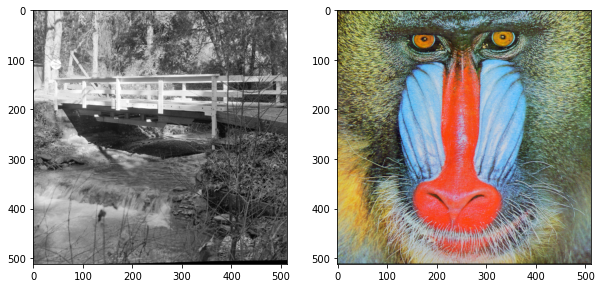

In [2]:
# -------------------
# --- Read images ---
# -------------------

import requests
from io import BytesIO

# Read images (images must be of the same size)
testImgs = ImgRead(enableJAX=False)

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
         3: requests.get('http://sipi.usc.edu/database/misc/4.2.05.tiff'),   # airplane (color)
         4: requests.get('http://sipi.usc.edu/database/misc/4.2.07.tiff'),   # peppers (color)
        }

testImgs = ImgRead(enableJAX=False)        # If JAX is installed but just want to use 
                                           # standard numpy, then we need to pass this flag (once)

testImgs.list.append([BytesIO(fname.get(0).content),'g'])
testImgs.list.append([BytesIO(fname.get(2).content),'c'])
  

u = testImgs.readListImgs()                  # read list of images, normalize them between 0 and 1
                                             # u   : original image
                                             # obs : u corrupted with noise (depends on noiseModels)

        
pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)    



## Generate observed images

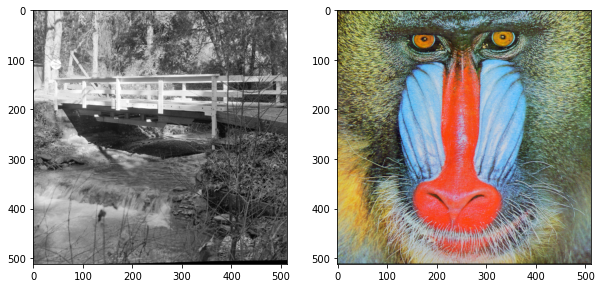

In [3]:
# --------------------------------------
# --- Set parameters for noise model ---
# --------------------------------------
    
noise = noiseModels(model=f2oDef.noise.Gaussian, sigma=0.0)
        
addNoise = noise.sel_NoiseModel()

z = addNoise(u)

pltImg.plotNImgs(z, len(z), None, 5)  

## Compute low / high pass filtered images

In [4]:
k = { 'bridge':   0,  # grayscale
      'mandrill': 1,  # color
    }.get('bridge')

uLP, uHP = testImgs.computeLPHP( z[k] , padFlag=True)

## Forward operator: randomly generated filterbank 

In [5]:

# Example of a random dictionary
Hrand = np.random.randn(12,12,36)    
for l in range(36):
    Hrand[:,:,l] /= np.sqrt( np.sum(Hrand[:,:,l]*Hrand[:,:,l]) )

  
# Select *frequency domain* routines (note the "_f"
freqOp         = fwOp_f(linOp=f2oDef.fAx_FB2D, A=Hrand)



## Setup optimziation problem

In [9]:
# -------------------------------------------------
# Define optimization class and general properties 
# -------------------------------------------------

args = F2O.argsF2O()

args.fCostClass  = f2oDef.cost.L2L1_lin    # f(x) = 0.5|| fAx(x) - b ||_2^2 + \lambda|| x ||_1
args.verbose     = True                    # Verbose ooutput
args.verboseStep = 5                       # default is 10

#args.padFlag     = False                   # padding in the Fourier domain
args.padFlag         = True
args.padMode         = 'symmetric'    
    
# -- specific parameters will be selected below
  

## Call the solver

In [18]:
# -----------------------------------------------  
# --- FISTA (frequency) + Barzilai-Borwein
# -----------------------------------------------

args.ssPolicy  = f2oDef.ss.BBv1        # step-size policiy
# Several other options, execute 
#  
# >>> f2oDef.ss.printSS()
#
# to list all the options

args.ISeqPolicy = f2oDef.iseq.ntrv      # inertial sequence


lmbda = 0.1
nIter = 50

x = []
Stats = []
solverTxt = []

# Note that the 'input' is the HP image (usual for CSC) 
sol = fAPG(freqOp, uHP, lmbda, nIter, args)
x.append(sol[0])
Stats.append(sol[1])
solverTxt.append('CSC')

# NOTE: since a random FB is used, then the input may the the image itself
sol = fAPG(freqOp, z[k], lmbda, nIter, args)
x.append(sol[0])
Stats.append(sol[1])
solverTxt.append('CSC-ELM')




Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 2.055e+03	 4.57e-03    4.22e-01    nan
  5	 1.158e+03	 6.48e-02    2.70e+00    2.707e-01
 10	 9.931e+02	 7.41e-02    5.00e+00    8.644e-02
 15	 9.685e+02	 2.60e-02    7.33e+00    4.688e-02
 20	 9.850e+02	 2.38e-02    9.63e+00    4.226e-02
 25	 9.985e+02	 2.82e-02    1.19e+01    5.131e-02
 30	 9.471e+02	 6.13e-02    1.43e+01    3.946e-02
 35	 9.368e+02	 1.74e-01    1.65e+01    2.802e-02
 40	 9.356e+02	 7.49e-02    1.89e+01    1.521e-02
 45	 9.370e+02	 2.94e-02    2.11e+01    1.325e-02
 49	 9.411e+02	 3.96e-02    2.30e+01    1.724e-02


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 3.736e+04	 7.55e-03    3.88e-01    nan
  5	 9.994e+03	 3.18e-02    2.66e+00    9.419e-02
 10	 9.532e+03	 2.75e-02    4.96e+00    8.665e-02
 15	 9.070e+03	 3.19e-02    7.26e+00    9.038e-02
 20	 8.385e+03	 3.55e-02    9.55e+00    7.225e-02
 25	 7.925e+03	 3.82e-02    1.19e+01    5.346e-02
 30	 7.652e+03	 3.83e-02    1.42e+01    3.999e-02


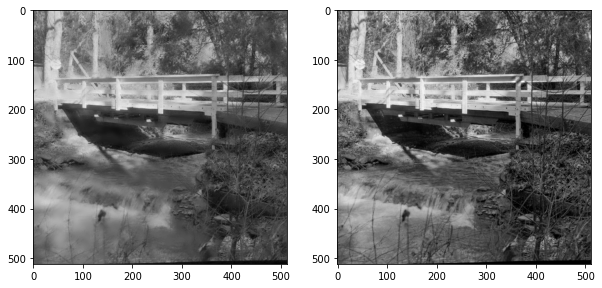

In [19]:
# Reconstruction
# ==============
  
uRec = []

uRec.append( freqOp.fRec(x[0], uLP) )       # uRec = fwOp(x) + uLP -- standard case
uRec.append( np.clip( freqOp.fRec(x[1], 0.*uLP), 0, 1) )    # CSC-ELM

pltImg  = ImgPlot()
pltImg.plotNImgs(uRec, len(uRec), None, 5)


[Text(0.5, 0, 'Time (sec.)')]

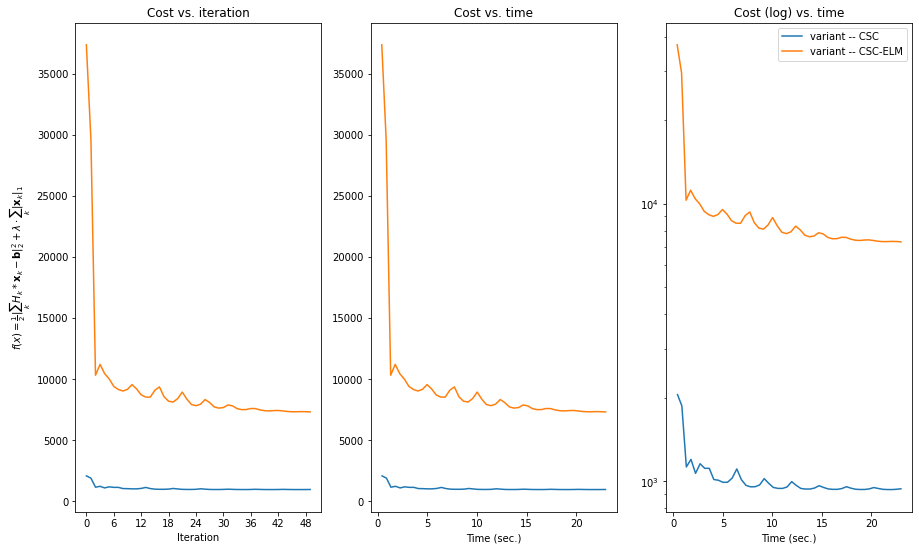

In [21]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator

# Plot cost functional ---
figure, f = PLT.subplots(ncols=3, figsize=(15, 9))
  
for n in range(len(x)):
    f[0].plot(Stats[n][:,0], label=r'variant -- {0}'.format(solverTxt[n]) )
  
f[0].set_title('Cost vs. iteration')
f[0].xaxis.set_major_locator(MaxNLocator(integer=True))  
PLT.setp(f[0], xlabel='Iteration', 
           ylabel=r'$f(x) = \frac{1}{2}\left\| \sum_k H_k * \mathbf{x}_k - \mathbf{b} \right\|_2^2 + \lambda \cdot \sum_k \| \mathbf{x}_k \|_1$')
  
  
for n in range(len(x)):
    f[1].plot(Stats[n][:,2], Stats[n][:,0], label=r'solver -- {0}'.format(solverTxt[n]) )

f[1].set_title('Cost vs. time')
PLT.setp(f[1], xlabel='Time (sec.)') 

    
for n in range(len(x)):
    f[2].semilogy(Stats[n][:,2], Stats[n][:,0], label=r'variant -- {0}'.format(solverTxt[n]) )
    
    
f[2].legend(loc='upper right',fontsize=10)
f[2].set_title('Cost (log) vs. time')
PLT.setp(f[2], xlabel='Time (sec.)') 
  